In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-10-30 22:49:57.974265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
features = pd.read_csv('features.csv', delimiter=',')
features.head()

,product,productionCost,minMarkup,maxMarkup,date,sales,stock
0,431989,212837,59,80,2022-08-01,0,80
1,431989,212837,59,80,2022-04-01,0,103
2,431989,212837,59,80,2022-07-01,0,83
3,431989,212837,59,80,2022-06-01,0,89
4,431989,212837,59,80,2022-03-01,0,106


In [3]:
prices = pd.read_csv('prices.csv', delimiter=',')
prices.head()

,product,shop,category,brand,oldPrice,price,status,date
0,13309700,283,621641,1813,NaN,549000,1,2022-01-01
1,24023512,284,206776,315,NaN,249000,1,2022-01-01
2,21658969,5482,338678,1823,NaN,2817300,1,2022-01-01
3,12034393,283,621641,36731,NaN,1499000,1,2022-01-01
4,15431027,820,111964,1823,NaN,6999000,1,2022-01-01


In [4]:
csv = prices.merge(features, left_on=['product', 'date'], right_on=['product', 'date'])
csv = csv.drop('oldPrice', axis=1)
csv = csv.loc[csv['shop'].notnull()]
csv['date'] = pd.to_datetime(csv['date'])
csv = csv.sort_values(by=['date'])
csv.head()

,product,shop,category,brand,price,status,date,productionCost,minMarkup,maxMarkup,sales,stock
0,12544335,1820,111932,793,1899000,1,2022-01-03,1032328,58,80,1,187
1024,29098596,528,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40
1023,29098596,3,112008,368,3479900,1,2022-01-03,19172316,7,80,2,40
1022,29098596,1816,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40
1021,29098596,1820,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40


In [5]:
csv.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
product,325910.0,1.533873e+07,1.063491e+07,398130.0,1614833.0,18654569.0,24677623.0,31878364.0
shop,325910.0,1.392192e+03,1.573120e+03,3.0,284.0,1075.0,1816.0,7254.0
category,325910.0,1.249673e+05,3.260734e+04,111932.0,111932.0,111932.0,112008.0,206686.0
brand,325910.0,2.040940e+03,1.098945e+04,6.0,681.0,695.0,793.0,134474.0
price,325910.0,8.188806e+06,1.116656e+07,35000.0,1699000.0,3449000.0,9799000.0,120899000.0
status,325910.0,1.155540e+00,5.289729e-01,1.0,1.0,1.0,1.0,3.0
productionCost,325910.0,5.923090e+06,8.766727e+06,165219.0,839745.0,1708412.0,7177074.0,60815701.0
minMarkup,325910.0,2.398456e+01,2.098307e+01,-3.0,9.0,12.0,44.0,86.0
maxMarkup,325910.0,8.000000e+01,0.000000e+00,80.0,80.0,80.0,80.0,80.0
sales,325910.0,3.734160e-01,9.369857e-01,-2.0,0.0,0.0,0.0,16.0


In [6]:
def get_shop_product(csv, shop, product):
    csv_sp = csv.loc[csv['product'] == product]
    csv_sp = csv.loc[csv['shop'] == shop]
    csv_sp = csv_sp.drop('product', axis=1)
    csv_sp = csv_sp.drop('shop', axis=1)
    date_time = pd.to_datetime(csv_sp.pop('date'))
    return csv_sp, date_time

In [7]:
csv_sp, date_time = get_shop_product(csv, 1816, 112008)
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day
csv_sp = csv_sp.assign(DaySin=np.sin(timestamp_s * (2 * np.pi / day)))
csv_sp = csv_sp.assign(DayCos=np.cos(timestamp_s * (2 * np.pi / day)))
csv_sp = csv_sp.assign(YearSin=np.sin(timestamp_s * (2 * np.pi / year)))
csv_sp = csv_sp.assign(YearCos=np.cos(timestamp_s * (2 * np.pi / year)))
csv_sp.head()

,category,brand,price,status,productionCost,minMarkup,maxMarkup,sales,stock,DaySin,DayCos,YearSin,YearCos
1022,112008,368,26989000,1,19172316,7,80,2,40,-5.522169e-14,1.0,0.041103,0.999155
1013,112008,2524,3399000,1,2709744,7,80,2,132,-5.522169e-14,1.0,0.041103,0.999155
1009,111932,681,799000,1,327225,12,80,0,11,-5.522169e-14,1.0,0.041103,0.999155
1008,111932,681,2439000,1,1462901,12,80,0,8,-5.522169e-14,1.0,0.041103,0.999155
977,111932,681,1289000,1,801612,12,80,1,212,-5.522169e-14,1.0,0.041103,0.999155


In [8]:
column_indices = {name: i for i, name in enumerate(csv_sp.columns)}

n = len(csv_sp)
train_df = csv_sp[0:int(n*0.7)]
val_df = csv_sp[int(n*0.7):int(n*0.9)]
test_df = csv_sp[int(n*0.9):]

num_features = csv_sp.shape[1]

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='price', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

2022-10-30 22:50:04.485262: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:50:04.561536: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:50:04.561587: I tensorflow/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:50:04.561846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

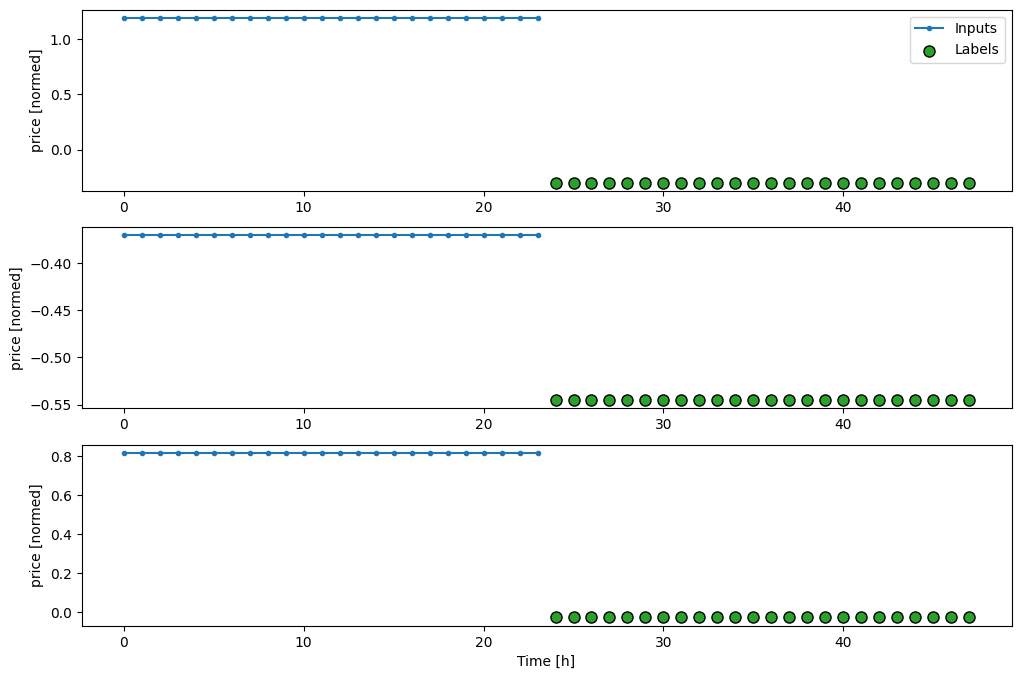

In [11]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window